In [1]:
# from VariationalBayes import ScalarParam, ModelParamsDict, VectorParam, PosDefMatrixParam
# from VariationalBayes.NormalParams import MVNParam, UVNParam, UVNParamVector
# from VariationalBayes.GammaParams import GammaParam
# from VariationalBayes.ExponentialFamilies import \
#     univariate_normal_entropy, multivariate_normal_entropy, gamma_entropy, \
#     mvn_prior, uvn_prior, gamma_prior

import VariationalBayes as vb
import LogisticGLMM_lib as logit_glmm
from VariationalBayes.SparseObjectives import Objective, SparseObjective

import matplotlib.pyplot as plt
%matplotlib inline

#import autograd.numpy as np
import numpy as np

from autograd import jacobian
# import autograd.numpy as np
# import autograd.numpy.random as npr
# import autograd.scipy as sp
# import scipy as osp

import copy
from scipy import optimize

In [5]:
# Load data saved by stan_results_to_json.R and run_stan.R in LRVBLogitGLMM.
import os
import json

simulate_data = True
prior_par = vb.ModelParamsDict('Prior Parameters')

if not simulate_data:
    #analysis_name = 'simulated_data_small'
    #analysis_name = 'simulated_data_large'
    analysis_name = 'criteo_subsampled'

    data_dir = os.path.join(os.environ['GIT_REPO_LOC'], 'LRVBLogitGLMM/LogitGLMMLRVB/inst/data/')
    json_filename = os.path.join(data_dir, '%s_stan_dat.json' % analysis_name)
    json_output_filename = os.path.join(data_dir, '%s_python_vb_results.json' % analysis_name)

    json_file = open(json_filename, 'r')
    json_dat = json.load(json_file)
    json_file.close()

    stan_dat = json_dat['stan_dat']
    vp_base = json_dat['vp_base']

    print(stan_dat.keys())
    K = stan_dat['K'][0]
    NObs = stan_dat['N'][0]
    NG = stan_dat['NG'][0]
    #N = NObs / NG
    y_g_vec = np.array(stan_dat['y_group'])
    y_vec = np.array(stan_dat['y'])
    x_mat = np.array(stan_dat['x'])
    
    mu_info_min = vp_base['mu_info_min'][0]
    tau_alpha_min = vp_base['tau_alpha_min'][0]
    tau_beta_min = vp_base['tau_beta_min'][0]
    beta_diag_min = vp_base['beta_diag_min'][0]
    u_info_min = vp_base['u_info_min'][0]
    
    # Define a class to contain prior parameters.
    prior_par.push_param(vb.VectorParam('beta_prior_mean', K, val=np.array(stan_dat['beta_prior_mean'])))
    beta_prior_info = np.linalg.inv(np.array(stan_dat['beta_prior_var']))
    prior_par.push_param(vb.PosDefMatrixParam('beta_prior_info', K, val=beta_prior_info))

    prior_par.push_param(vb.ScalarParam('mu_prior_mean', val=stan_dat['mu_prior_mean'][0]))
    prior_par.push_param(vb.ScalarParam('mu_prior_info', val=1 / stan_dat['mu_prior_var'][0]))

    prior_par.push_param(vb.ScalarParam('tau_prior_alpha', val=stan_dat['tau_prior_alpha'][0]))
    prior_par.push_param(vb.ScalarParam('tau_prior_beta', val=stan_dat['tau_prior_beta'][0]))

    # An index set to make sure jacobians match the order expected by R.
    prior_par_indices = copy.deepcopy(prior_par)
    prior_par_indices.set_name('Prior Indices')
    prior_par_indices.set_vector(np.array(range(prior_par_indices.vector_size())))
else:
    # Simulate data instead of loading it if you like
    N = 200     # observations per group
    K = 5      # dimension of regressors
    NG = 200      # number of groups

    # Generate data

    true_beta = np.array(range(5))
    true_beta = true_beta - np.mean(true_beta)
    true_mu = 0.
    true_tau = 40.0

    x_mat, y_g_vec, y_vec, true_rho, true_u = \
        logit_glmm.simulate_data(N, NG, true_beta, true_mu, true_tau)

    prior_par.push_param(vb.VectorParam('beta_prior_mean', K, val=np.zeros(K)))
    prior_par.push_param(vb.PosDefMatrixParam('beta_prior_info', K, val=0.01 * np.eye(K)))

    prior_par.push_param(vb.ScalarParam('mu_prior_mean', val=0))
    prior_par.push_param(vb.ScalarParam('mu_prior_info', val=0.5))

    prior_par.push_param(vb.ScalarParam('tau_prior_alpha', val=3.0))
    prior_par.push_param(vb.ScalarParam('tau_prior_beta', val=10.0))
    
    mu_info_min = 0.001
    tau_alpha_min = 0.001
    tau_beta_min = 0.001
    beta_diag_min = 0.001
    u_info_min = 0.001
    

print(np.mean(y_vec))

0.4973


In [6]:
# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
glmm_par = vb.ModelParamsDict('GLMM Parameters')

# print(vp_base)

glmm_par.push_param(
    vb.UVNParam('mu', min_info=mu_info_min))
glmm_par.push_param(
    vb.GammaParam('tau', min_shape=tau_alpha_min, min_rate=tau_beta_min))
glmm_par.push_param(vb.MVNParam('beta', K, min_info=beta_diag_min))
glmm_par.push_param(vb.UVNParamVector('u', NG, min_info=u_info_min))

# glmm_par.push_param(vb.UVNParam('mu', min_info=0.))
# glmm_par.push_param(vb.GammaParam('tau',
#                                    min_shape=0.,
#                                    min_rate=0.))
# glmm_par.push_param(vb.MVNParam('beta', K, min_info=0.))
# glmm_par.push_param(vb.UVNParamVector('u', NG, min_info=0.))

glmm_init = True
if glmm_init and not simulate_data:
    # Initialize with GLMM.  Don't forget to add the ADVI computation time to your final VB time!
    glmm_time = 0.

    glmm_fit = json_dat['glmm_fit']
    glmm_par['mu'].mean.set(glmm_fit['mu_mean'][0])
    glmm_par['mu'].info.set(1.0)

    tau_mean = 1.0 / glmm_fit['mu_sd'][0] ** 2
    tau_var = 1.0
    glmm_par['tau'].shape.set((tau_mean ** 2) / tau_var)
    glmm_par['tau'].rate.set(tau_var / tau_mean)

    glmm_par['beta'].mean.set(np.array(glmm_fit['beta_mean']))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.array(glmm_fit['u_map']))
    glmm_par['u'].info.set(np.full(NG, 1.0))

    free_par_vec = glmm_par.get_free()
else:
    glmm_time = 0.
    glmm_par['mu'].mean.set(0.0)
    glmm_par['mu'].info.set(1.0)

    glmm_par['tau'].shape.set(2.0)
    glmm_par['tau'].rate.set(2.0)

    glmm_par['beta'].mean.set(np.full(K, 0.0))
    glmm_par['beta'].info.set(np.eye(K))

    glmm_par['u'].mean.set(np.full(NG, 0.0))
    glmm_par['u'].info.set(np.full(NG, 1.0))

free_par_vec = glmm_par.get_free()
init_par_vec = copy.deepcopy(free_par_vec)


In [ ]:
# trlib has a memory error if the dataset is too large.
if False:
    import trlib

    glmm_par_local = copy.deepcopy(glmm_par)
    def foo():
        return sum(glmm_par_local.get_vector())


    tr_obj = Objective(glmm_par_local, foo)


    def f(par):
        return -1. * tr_obj.fun_free(par)

    def g(par):
        return -1. * tr_obj.fun_free_grad(par)

    def hvp(par, vec):
        return -1. * tr_obj.fun_free_hvp(par, vec)

    # f(init_par_vec)
    # g(init_par_vec)

    trlib.umin(f, g, hvp, init_par_vec)
    
    #print(init_par_vec)
    print(objective.fun_free(init_par_vec, verbose=True)[0])
    print(objective.fun_free_grad(init_par_vec))
    print(objective.fun_free_hvp(init_par_vec, init_par_vec))

    init_par_vec = np.random.random(model.glmm_par.free_size())

    # Memory error with large datasets.
    # tr_min = trlib.umin(
    #     obj=objective.fun_free,
    #     grad=objective.fun_free_grad,
    #     hessvec=objective.fun_free_hvp,
    #     x=init_par_vec)


In [9]:
# Define moment parameters

moment_wrapper = logit_glmm.MomentWrapper(glmm_par)
get_moment_jacobian = jacobian(moment_wrapper.get_moments)

# Moment indices.
moment_indices = copy.deepcopy(moment_wrapper.moment_par)
moment_indices.set_vector(1 + np.array(range(moment_indices.vector_size())))

model = logit_glmm.LogisticGLMM(glmm_par, prior_par, x_mat, y_vec, y_g_vec, 10)
model.get_e_log_prior()
model.get_log_lik()
model.get_entropy()

objective = Objective(model.glmm_par, model.get_kl)
objective.fun_free(free_par_vec)

# # PriorHess evaluates the second order derivative d2 EPrior / dpar dprior_par
# PriorModelGrad = grad(kl_wrapper.ExpectedLogPrior, argnum=0)
# PriorHess = jacobian(PriorModelGrad, argnum=1)

# kl_wrapper.ExpectedLogPrior(free_par_vec, prior_par.get_vector())

import timeit

time_num = 10

print('Function time:')
print(timeit.timeit(lambda: objective.fun_free(free_par_vec), number=time_num) / time_num)

print('Grad time:')
print(timeit.timeit(lambda: objective.fun_free_grad(free_par_vec), number=time_num) / time_num)

print('Hessian vector product time:')
print(timeit.timeit(lambda: objective.fun_free_hvp(free_par_vec, free_par_vec + 1), number=time_num) / time_num)

array([ 76960.14605639])

In [11]:
glmm_par_opt = copy.deepcopy(glmm_par)
def tr_optimize(trust_init, num_draws, maxiter=500):
    model.set_draws(num_draws)
    objective.logger.initialize()
    objective.logger.print_every = 5
    vb_opt = optimize.minimize(
        lambda par: objective.fun_free(par, verbose=True),
        x0=trust_init,
        method='trust-ncg',
        jac=objective.fun_free_grad,
        hessp=objective.fun_free_hvp,
        tol=1e-6, options={'maxiter': maxiter, 'disp': True, 'gtol': 1e-6 })
    return vb_opt.x

def get_moment_vec(vb_opt_x):
    glmm_par_opt.set_free(vb_opt_x)
    set_moments(glmm_par_opt, moment_par)
    return moment_par.get_vector()


In [12]:
import pandas as pd
#print(glmm_par)

x_t_x = np.matmul(x_mat.transpose(), x_mat)
x_t_y = np.matmul(x_mat.transpose(), y_vec)
beta_init = np.linalg.solve(x_t_x, x_t_y)
#print(beta_init)
#plt.plot(sp.special.expit(np.matmul(x_mat, beta_init)), y_vec, 'k.')

df = pd.DataFrame({ 'y_g': y_g_vec, 'y': y_vec}).groupby('y_g')
#print(df.sum())
u_init = np.array(df.sum()) / np.array(df.count()['y'])
#plt.figure()
print(np.min(y_g_vec))
#plt.plot(u_init[y_g_vec], y_vec, 'k.')


0


In [13]:
import time

# Optimize.
num_mc_draws = 3

print('Running Newton Trust Region')
vb_time = time.time()
opt_x = tr_optimize(init_par_vec, num_mc_draws, maxiter=100)
vb_time = time.time() - vb_time

print('Done.')

Running Newton Trust Region
Iter  0  value:  [ 74944.26335334]
Iter  5  value:  [ 36768.81753565]
Iter  10  value:  [-5502.47038227]
Iter  15  value:  [-22668.56078258]
Iter  20  value:  [-53529.42243194]
Iter  25  value:  [-87539.33620241]
Iter  30  value:  [-105864.99490848]
Iter  35  value:  [-106450.16937417]
Iter  40  value:  [-106468.78481938]
Iter  45  value:  [-106468.84727557]
Optimization terminated successfully.
         Current function value: -106468.847276
         Iterations: 47
         Function evaluations: 48
         Gradient evaluations: 46
         Hessian evaluations: 0
Done.


Fit beta:  [-2.00245181 -1.01682419  0.02317739  0.95615767  1.97296369]
True beta:  [-2. -1.  0.  1.  2.]
Fit mu:  [-0.0099802]
True mu:  0.0
Fit tau:  [ 1990.24821949]
True tau:  40.0


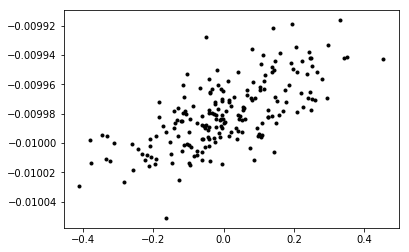

In [17]:
glmm_par.set_free(opt_x)
if simulate_data:
    print('Fit beta: ', glmm_par['beta'].e())
    print('True beta: ', true_beta)
    
    print('Fit mu: ', glmm_par['mu'].e())
    print('True mu: ', true_mu)
    
    print('Fit tau: ', glmm_par['tau'].e())
    print('True tau: ', true_tau)
    
    plt.plot(true_u, true_u, 'r.')
    plt.plot(true_u, glmm_par['u'].e(), 'k.')
    

In [ ]:
import scipy as sp

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
#glmm_par_opt.set_free(init_par_vec)
print(glmm_fit['beta_mean'])
print(glmm_par_opt['beta'].e())
print(glmm_par_opt)

#plt.plot(glmm_par_opt['u'].e(), glmm_par_opt['u'].var(), 'k.')

e_beta = glmm_par_opt['beta'].e()
e_u = glmm_par_opt['u'].e()[model.y_g_vec]

z_mean = e_u + np.matmul(model.x_mat, e_beta)
#plt.plot(sp.special.expit(z_mean), model.y_vec, 'k.')


plt.figure()
plt.hist(z_mean[model.y_vec == 1], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 1')

plt.figure()
plt.hist(z_mean[model.y_vec == 0], 50, normed=1, facecolor='green', alpha=0.75)
plt.title('y == 0')




In [ ]:
print(len(opt_x))
print(glmm_par.free_size())

glmm_par_opt = copy.deepcopy(glmm_par)
glmm_par_opt.set_free(opt_x)
moment_wrapper.glmm_par.set_free(opt_x)
moment_wrapper.set_moments()

print(vb_time / 60)

In [ ]:
if False:
    # Investigate the performance of different numbers of draws.   It doesn't appear to
    # converge.
    opt_x_20 = tr_optimize(init_par_vec, 20)
    opt_x_60 = tr_optimize(opt_x_20, 60)
    opt_x_100 = tr_optimize(opt_x_60, 100)
    opt_x_200 = tr_optimize(opt_x_100, 200)
    opt_x_400 = tr_optimize(opt_x_200, 400)
    opt_x_800 = tr_optimize(opt_x_400, 800)
    
    mom_20 = get_moment_vec(opt_x_20)
    mom_60 = get_moment_vec(opt_x_60)
    mom_100 = get_moment_vec(opt_x_100)
    mom_200 = get_moment_vec(opt_x_200)
    mom_400 = get_moment_vec(opt_x_400)
    mom_800 = get_moment_vec(opt_x_800)

    print np.max(np.abs((mom_20 - mom_60) / mom_20))
    print np.max(np.abs((mom_60 - mom_100) / mom_60))
    print np.max(np.abs((mom_100 - mom_200) / mom_100))
    print np.max(np.abs((mom_200 - mom_400) / mom_200))
    print np.max(np.abs((mom_400 - mom_800) / mom_400))

    print '-------\n'
    print np.max(np.abs((mom_20 - mom_60)))
    print np.max(np.abs((mom_60 - mom_100)))
    print np.max(np.abs((mom_100 - mom_200)))
    print np.max(np.abs((mom_200 - mom_400)))
    print np.max(np.abs((mom_400 - mom_800)))

    #diff_inds = np.where(np.abs(mom_60 - mom_100) > 1e-2)
    #print diff_inds
    #print moment_indices

    #print (get_moment_vec(opt_x_60) - get_moment_vec(opt_x_100)) / np.abs(get_moment_vec(opt_x_100))
    get_moment_vec(opt_x_200)
    u200 = copy.deepcopy(moment_par['e_u'].get())
    get_moment_vec(opt_x_400)
    u400 = copy.deepcopy(moment_par['e_u'].get())
    get_moment_vec(opt_x_800)
    u800 = copy.deepcopy(moment_par['e_u'].get())


In [ ]:
# Examine why the means are different for different number of simulations.
def get_logit_terms(num_draws):
    model.set_draws(num_draws)
    std_draws = model.std_draws

    e_beta = glmm_par_opt['beta'].mean.get()
    info_beta = glmm_par_opt['beta'].info.get()
    cov_beta = np.linalg.inv(info_beta)

    e_u = glmm_par_opt['u'].mean.get()[y_g_vec]
    info_u = glmm_par_opt['u'].info.get()[y_g_vec]
    var_u = 1 / info_u

    z_mean = e_u + np.matmul(x_mat, e_beta)
    z_sd = np.sqrt(var_u + np.einsum('nk,kj,nj->n', x_mat, cov_beta, x_mat))
    z = np.einsum('i,j->ij', z_sd, std_draws) + np.expand_dims(z_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # p = exp(z) / (1 + exp(z))
    # log(1 - p) = log(1 / (1 + exp(z))) = -log(1 + exp(z))
    logit_terms = np.log1p(np.exp(z))
    logit_term = -np.sum(logit_terms) / std_draws.size

    return logit_term, logit_terms, z
    
logit_term_50, logit_terms_50, z_50 = get_logit_terms(50)    
logit_term_800, logit_terms_800, z_800 = get_logit_terms(800)

print( logit_term_50)
print( logit_term_800)

logit_terms_50_mean = np.mean(logit_terms_50, 1)
logit_terms_800_mean = np.mean(logit_terms_800, 1)

print( np.max(np.abs(logit_terms_50_mean - logit_terms_800_mean)))
print( np.where(np.abs(logit_terms_50_mean - logit_terms_800_mean) > 1e-3))

ind = 3
plt.plot(z_800[ind, :], logit_terms_800[ind, :])
plt.plot(z_50[ind, :], logit_terms_50[ind, :])
print( logit_terms_50_mean[ind])
print( logit_terms_800_mean[ind])


In [ ]:
# Get the Hessians at the number of draws used for optimization.

model.set_draws(num_mc_draws)

hess_time = time.time()
print('KL Hessian:\n')
kl_hess = objective.fun_free_hessian(opt_x)

print('Log prior Hessian:\n')
log_prior_hess = PriorHess(opt_x, prior_par.get_vector())

hess_time =  time.time() - hess_time
elbo_hess = -kl_hess

print('hess_time: %f' % hess_time)

In [ ]:
moment_jac = MomentJacobian(opt_x)
lrvb_cov = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))

prior_indices = copy.deepcopy(prior_par)
prior_indices.set_vector(1 + np.array(range(prior_indices.vector_size())))

vp_indices = copy.deepcopy(glmm_par_opt)
vp_indices.set_vector(1 + np.array(range(vp_indices.vector_size())))

In [ ]:
if not simulate_data:
    # Write the result to a JSON file for use in R.
    
    run_name = 'production'
    result_dict = { 'glmm_par_opt': glmm_par_opt.dictval(), 'run_name': run_name,
                    'vb_time': vb_time, 'hess_time': hess_time, 'num_mc_draws': num_mc_draws, 
                    'moment_indices': moment_indices.dictval(),
                    'prior_indices': prior_indices.dictval(),
                    'vp_indices': vp_indices.dictval(),
                    'lrvb_cov': lrvb_cov.tolist(), 'moment_jac': moment_jac.tolist(),
                    'elbo_hess': elbo_hess.tolist(), 'log_prior_hess': log_prior_hess.tolist() }

    result_json = json.dumps(result_dict)
    json_file = open(json_output_filename, 'w')
    json_file.write(result_json)
    json_file.close()

    print(json_output_filename)